# Sustainability project - data analysis

Notebook for data visualization and analysis

In [1]:
import sys
sys.path.append('/Users/fabiomenegazzo/Documents/Università/codes')
import os
import json
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 20
plt.rcParams['pcolor.shading'] = 'auto'
from helpers import *
from Gillespie import *
from CPRsust_rates import *
from extinctionTimes import *
from CPRSust_detEqs import *

tolerance = 1e-3
cutFrac = 0.8

inputCommonDir = 'output' 
if not os.path.isdir(inputCommonDir):
    raise FileNotFoundError(f'Folder for the inputs not found at relative path: {inputCommonDir}. Perform the data prduction first.')
methodsStrVec = ['MF','detRes','stocRes']
intputDirsVec = [inputCommonDir+'/'+s for s in methodsStrVec]

paramsLabel = 'parameters'
seriesLabel = 'series'

## Mean field

In [2]:
fileList_MF = [f for f in os.listdir(intputDirsVec[0]) if f.endswith('.json')]
if not fileList_MF:
    print('No data found.')
    runMF = False
else:
    print(f'{len(fileList_MF)} files found.')
    runMF = True

    print('Importing.')
    dataObj_MF = []
    for fName in fileList_MF:
        with open(os.path.join(intputDirsVec[0], fName), 'r') as f:
            data = json.load(f)
            dataObj_MF.append(data)
    print('Done.')

9 files found.
Importing.
Done.


### Visualize a single time series

Paremeter set
{
    "N": 200,
    "b": 1.0,
    "ehatC": 0.7,
    "ehatD": 1.55,
    "xi": 0.5,
    "Ri": 0.5
}

Evaluating the time to extinction
	Done.


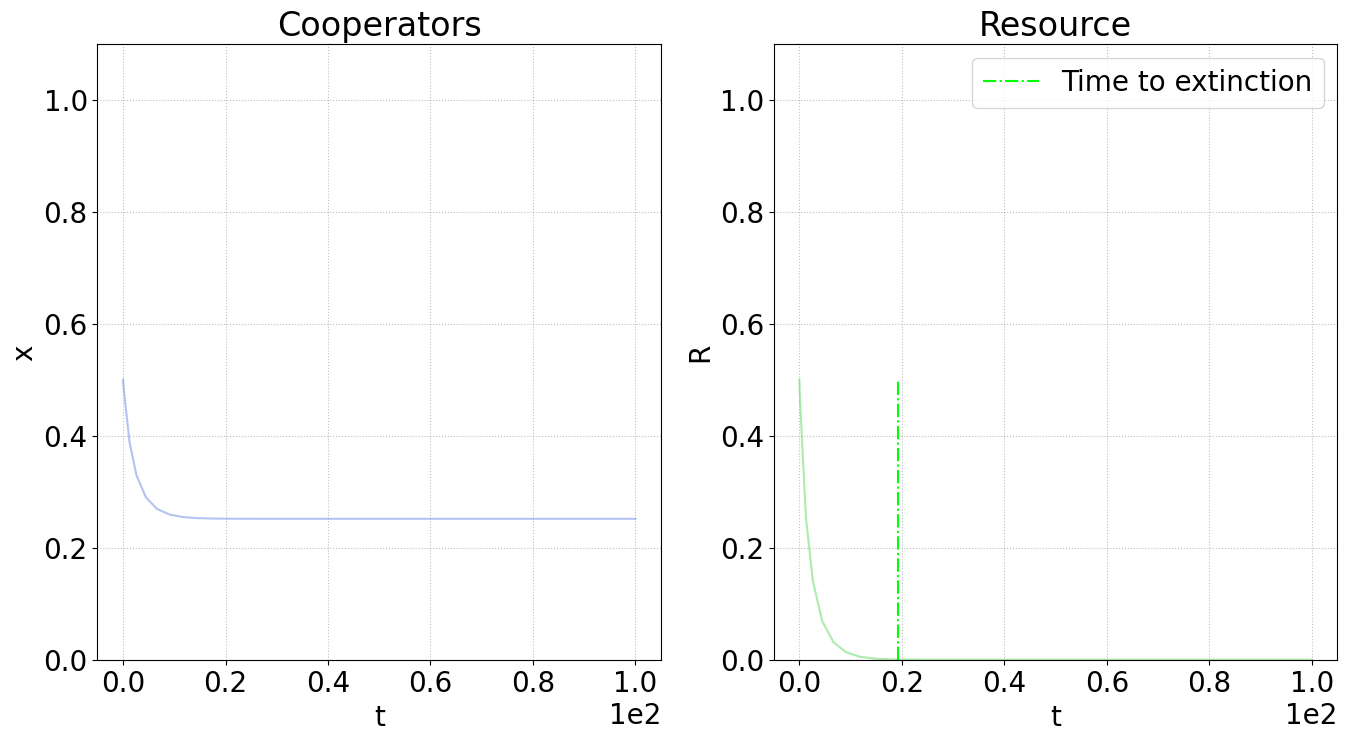

In [3]:
if runMF:
    idxVis_MF = 0

    paramsDictVis_MF =dataObj_MF[idxVis_MF][paramsLabel]
    print('Paremeter set')
    print(json.dumps(paramsDictVis_MF, indent=4))
    seriesObjVis_MF = dataObj_MF[idxVis_MF][seriesLabel]

    # Time to extinction
    print('\nEvaluating the time to extinction')
    tExt_MF = extinctionTime_single(seriesObjVis_MF['time'],seriesObjVis_MF['resource'],tolerance)
    if not tExt_MF:
        print('\tDone. The resource remains sustainable!')
        seriesObjVis_MF['absorbing'] = False
    else:
        seriesObjVis_MF['absorbing'] = True
    print('\tDone.')

    plotsObj = [
        {
            'name' : 'Cooperators',
            'x' : seriesObjVis_MF['time'],
            'y': seriesObjVis_MF['cooperators'],
            'color' : 'royalblue',
            'xlabel' : 't',
            'ylabel' : 'x',
            'yLims' : [0, 1.1]
        },
        {
            'name' : 'Resource',
            'x' : seriesObjVis_MF['time'],
            'y' : seriesObjVis_MF['resource'],
            'color' : 'limegreen',
            'xlabel' : 't',
            'ylabel' : 'R',
            'yLims' : [0,1.1]
        }
    ]

    fig_MF, ax_MF = plt.subplots(1,2,figsize=(16,8))

    for ax,plotObj in zip(ax_MF,plotsObj):
        ax.set_title(plotObj['name'])
        ax.plot(plotObj['x'],plotObj['y'],plotObj['color'], alpha=0.4)
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
        ax.set_xlabel(plotObj['xlabel'])
        ax.set_ylabel(plotObj['ylabel'])
        ax.set_ylim(plotObj['yLims'])
        ax.grid(which='both',linestyle=':',color='k',alpha=0.25)
    if tExt_MF:
        ax_MF[1].vlines(tExt_MF,0,paramsDictVis_MF['Ri'],colors='lime',linestyle='-.',label='Time to extinction')
        ax_MF[1].legend()
    plt.show()

### Phase diagram

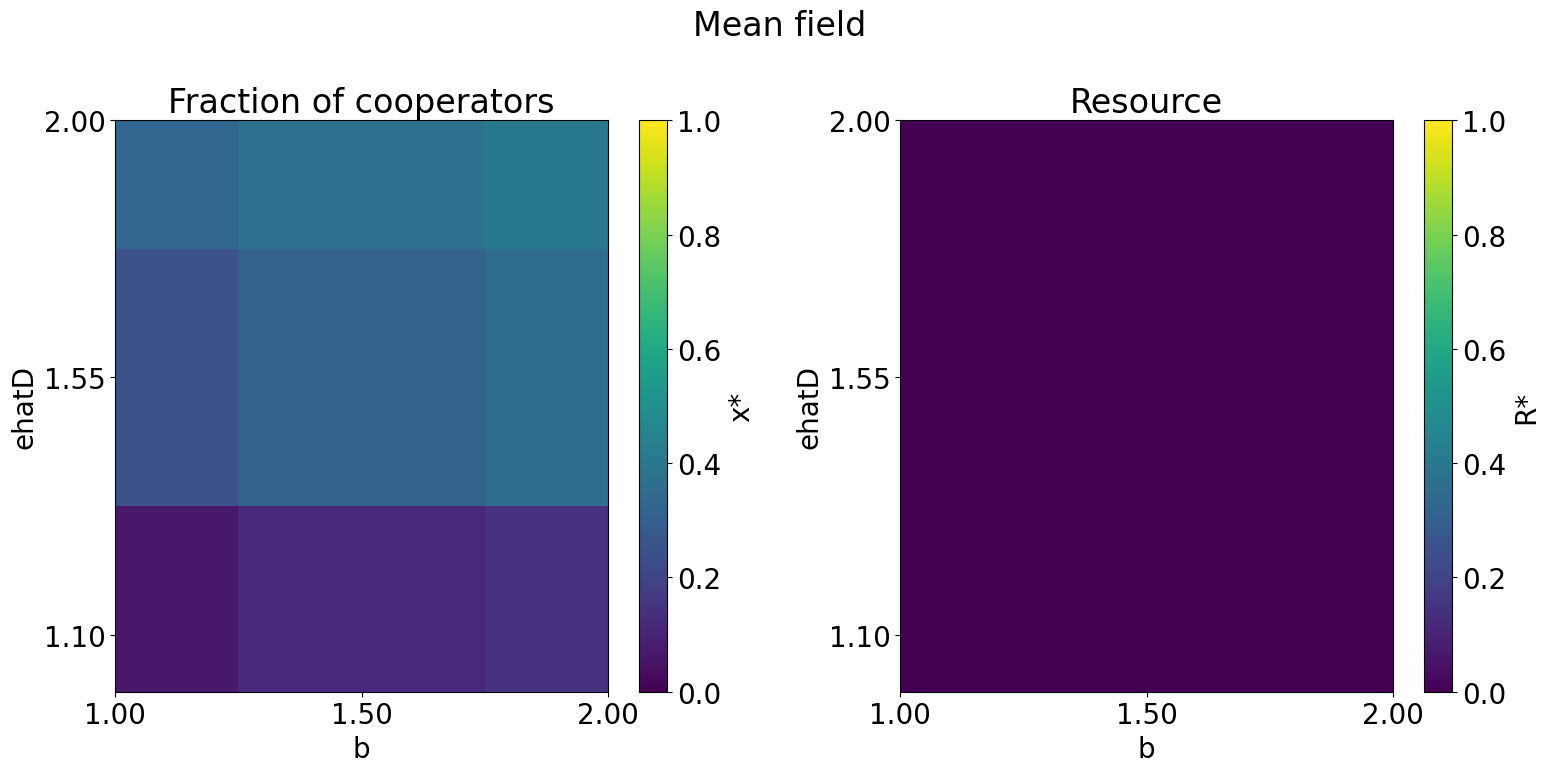

In [10]:
def stationaryMean(x,y,cut):
    x = np.array(x)
    y = np.array(y)
    idxList = np.where(x > cut)[0]
    if len(idxList)==0:
        raise ValueError('No data satisfying the cut-off detected!')
    return np.mean(y[idxList])

# Collecting the data
paramsGenericDict_MF = paramsDictVis_MF.copy()

# Pair of parameters over which to build the PD
PDParamLabels_MF = ['b','ehatD']

# Object of blocked parameters
fixedParams_MF = {k:v for k,v in paramsGenericDict_MF.items() if k not in PDParamLabels_MF}

# print(json.dumps(fixedParams_MF, indent=4))

# Take only the date sets with the chosen parameters fixed
dataObjPD_MF = []
for obj in dataObj_MF:
    params_temp = obj[paramsLabel]
    if all(params_temp.get(k) == v for k, v in fixedParams_MF.items()):
        dataObjPD_MF.append(obj)

paramsPDGrid = []
xStat = []
RStat = []
for obj in dataObjPD_MF:
    paramsAll = obj[paramsLabel]
    param1PD = paramsAll[PDParamLabels_MF[0]]
    param2PD = paramsAll[PDParamLabels_MF[1]]
    paramsPDGrid.append({k: v for k,v in zip(PDParamLabels_MF,[param1PD,param2PD])})

    t = obj[seriesLabel]['time']
    x = obj[seriesLabel]['cooperators']
    R = obj[seriesLabel]['resource']

    cut = cutFrac*t[-1]
    xStat.append(stationaryMean(t,x,cut))
    RStat.append(stationaryMean(t,R,cut))

# Stuff for working with the plot function
p1PD_allVals = [d[PDParamLabels_MF[0]] for d in paramsPDGrid]
p2PD_allVals = [d[PDParamLabels_MF[1]] for d in paramsPDGrid]
p1PD_uniqueVals = np.unique(p1PD_allVals)
p2PD_uniqueVals = np.unique(p2PD_allVals)
p1Meshgrid, p2Meshgrid = np.meshgrid(p1PD_uniqueVals,p2PD_uniqueVals)
xStatMeshgrid = np.full(p1Meshgrid.shape,np.nan)
RStatMeshgrid = xStatMeshgrid.copy()
for (p1, p2, xS, RS) in zip(p1PD_allVals, p2PD_allVals, xStat, RStat):
    i = np.where(p1PD_uniqueVals == p1)[0][0]
    j = np.where(p2PD_uniqueVals == p2)[0][0]
    xStatMeshgrid[j, i] = xS
    RStatMeshgrid[j, i] = RS

# Actual plot
figPD_MF, axPD_MF = plt.subplots(1,2,figsize=(16,8))
figPD_MF.suptitle('Mean field')

PDxS_MF = axPD_MF[0].pcolormesh(p1Meshgrid,p2Meshgrid,xStatMeshgrid,shading='auto',vmin=0,vmax=1)
figPD_MF.colorbar(PDxS_MF, ax=axPD_MF[0], label='x*')

PDRS_MF = axPD_MF[1].pcolormesh(p1Meshgrid, p2Meshgrid, RStatMeshgrid,vmin=0,vmax=1)
figPD_MF.colorbar(PDRS_MF, ax=axPD_MF[1], label='R*')

axPD_MF[0].set_title('Fraction of cooperators')
axPD_MF[1].set_title('Resource')

for ax in axPD_MF:
    ax.set_xlabel(PDParamLabels_MF[0])
    ax.set_ylabel(PDParamLabels_MF[1])
    ax.set_xticks(p1PD_uniqueVals)
    ax.set_yticks(p2PD_uniqueVals)
    ax.set_xticklabels([f'{val:.2f}' for val in p1PD_uniqueVals])
    ax.set_yticklabels([f'{val:.2f}' for val in p2PD_uniqueVals])
    ax.set_xlim([1,2])
    ax.set_ylim([1,2])

plt.tight_layout()
plt.show()